# 10장 설명가능한 XAI (Explainable AI)

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
# 한글 폰트 설치

!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [ ]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name  # window font

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

## Import modules

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms


In [4]:
np.random.seed(123)
torch.manual_seed(123)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cuda


## Define model architecture

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

## Define training and inference routines

In [32]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        if b_i % 100 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), 
                loss.item()))

In [33]:

def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y).item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1)  # us argmax to get the most likely prediction
            # ipdb.set_trace()
            # success += pred.eq(y.view_as(pred)).sum().item()
            success += (pred == y).float().mean()

    loss /= len(test_dataloader)
    success /= len(test_dataloader)
    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {:.3f}%'.format(
        loss, 100. * success))


## Create data loaders

In [34]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
path = os.path.join(os.getcwd(), "data")

train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(path, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
                    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(path, train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,)) 
                   ])),
                    batch_size=500, shuffle=True)

## Define optimizer and run training epochs

In [35]:
# device = torch.device("cuda")

model = ConvNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

## model training

In [36]:
for epoch in range(1, 10):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

epoch: 1 [0/60000 (0%)]	 training loss: 2.350399
epoch: 1 [3200/60000 (5%)]	 training loss: 0.505442
epoch: 1 [6400/60000 (11%)]	 training loss: 0.375832
epoch: 1 [9600/60000 (16%)]	 training loss: 0.174613
epoch: 1 [12800/60000 (21%)]	 training loss: 0.094870
epoch: 1 [16000/60000 (27%)]	 training loss: 0.248784
epoch: 1 [19200/60000 (32%)]	 training loss: 0.116714
epoch: 1 [22400/60000 (37%)]	 training loss: 0.100887
epoch: 1 [25600/60000 (43%)]	 training loss: 0.122702
epoch: 1 [28800/60000 (48%)]	 training loss: 0.011258
epoch: 1 [32000/60000 (53%)]	 training loss: 0.047116
epoch: 1 [35200/60000 (59%)]	 training loss: 0.021475
epoch: 1 [38400/60000 (64%)]	 training loss: 0.019994
epoch: 1 [41600/60000 (69%)]	 training loss: 0.234944
epoch: 1 [44800/60000 (75%)]	 training loss: 0.120182
epoch: 1 [48000/60000 (80%)]	 training loss: 0.124250
epoch: 1 [51200/60000 (85%)]	 training loss: 0.054578
epoch: 1 [54400/60000 (91%)]	 training loss: 0.138368
epoch: 1 [57600/60000 (96%)]	 trainin

## Run inference on trained model

4


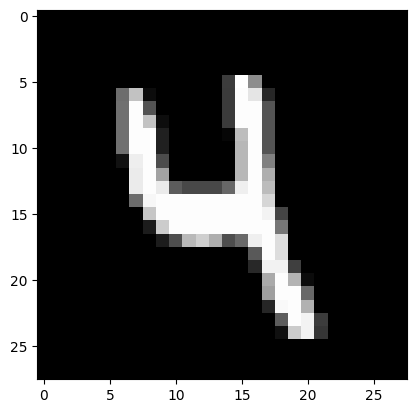

In [37]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

idx = np.random.randint(0, len(sample_targets))
print(sample_targets[idx].item())
plt.imshow(sample_data[idx][0], cmap='gray', interpolation='none')
plt.show()

In [38]:
idx = np.random.randint(0, len(sample_targets))
sample_data = sample_data.to(device)
print(f"Model prediction is : {model(sample_data).data.max(1)[1][idx]}")
print(f"Ground truth is : {sample_targets[idx]}")

Model prediction is : 8
Ground truth is : 8


### visualize filters

In [39]:
dict(model.named_parameters()).keys()

dict_keys(['cn1.weight', 'cn1.bias', 'cn2.weight', 'cn2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [40]:
model_children_list = list(model.children())
convolutional_layers = []
model_parameters = []
model_children_list
# len(model_children_list)
print("model_children_list[0] = ", model_children_list[0])
print("type(model_children_list[0]) = ", type(model_children_list[0]))
type(model_children_list[0]) == nn.Conv2d # true

print("model_children_list[2] = ", model_children_list[2])
print("type(model_children_list[2]) = ", type(model_children_list[2]))
type(model_children_list[2]) == nn.Dropout2d # true

model_children_list[0] =  Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
type(model_children_list[0]) =  <class 'torch.nn.modules.conv.Conv2d'>
model_children_list[2] =  Dropout2d(p=0.1, inplace=False)
type(model_children_list[2]) =  <class 'torch.nn.modules.dropout.Dropout2d'>


True

In [41]:
for i in range(len(model_children_list)):
    if type(model_children_list[i]) == nn.Conv2d:
        model_parameters.append(model_children_list[i].weight)
        convolutional_layers.append(model_children_list[i])

# len(model_parameters) # 2
# len(model_parameters[0]) # 16
# len(model_parameters[1]) # 32

In [42]:
len(model_parameters) # 2
print(model_parameters[0].shape) # len(model_parameters) # 2
print(model_parameters[1].shape) # torch.Size([32, 16, 3, 3])

torch.Size([16, 1, 3, 3])
torch.Size([32, 16, 3, 3])


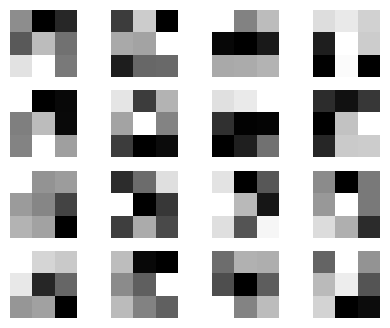

In [43]:
plt.figure(figsize=(5, 4))
for i, flt in enumerate(model_parameters[0]): #
    plt.subplot(4, 4, i+1)
    plt.imshow(flt[0, :, :].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()


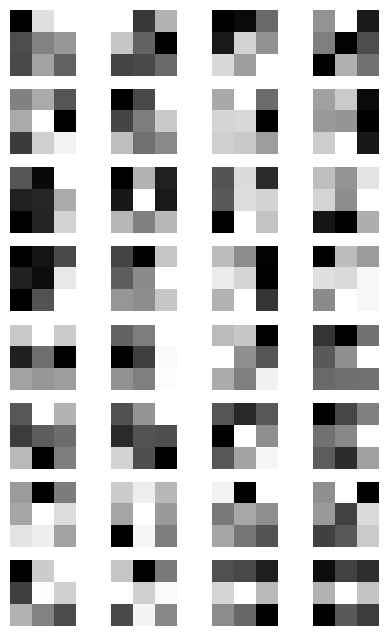

In [44]:
plt.figure(figsize=(5, 8))
for i, flt in enumerate(model_parameters[1]):
    plt.subplot(8, 4, i+1)
    plt.imshow(flt[0, :, :].cpu().detach(), cmap='gray')
    plt.axis('off')
plt.show()

### Visualize feature maps

In [45]:
sample_data.shape

torch.Size([500, 1, 28, 28])

[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))]

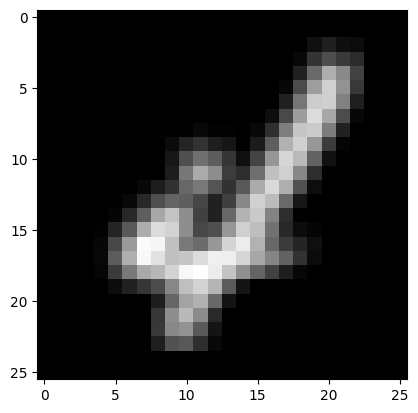

In [46]:
display(convolutional_layers)
per_layer_results = convolutional_layers[0](sample_data)
per_layer_results.shape # torch.Size([500, 16, 26, 26])

plt.imshow(per_layer_results[-1].cpu().data.numpy()[0], cmap = "gray_r")
plt.show()

In [47]:
per_layer_results[-1].shape

torch.Size([16, 26, 26])

In [48]:
per_layer_results = [convolutional_layers[0](sample_data)] # [torch.Size([500, 16, 26, 26])]
for i in range(1, len(convolutional_layers)): 
    per_layer_results.append(convolutional_layers[i](per_layer_results[-1])) # last feature

print(len(per_layer_results))
print("per_layer_results[0] = ")
print(per_layer_results[0].shape)
print(per_layer_results[1].shape)

2
per_layer_results[0] = 
torch.Size([500, 16, 26, 26])
torch.Size([500, 32, 24, 24])


In [49]:
per_layer_results[0].shape[0]

500

torch.Size([16, 26, 26])
<class 'torch.Tensor'>


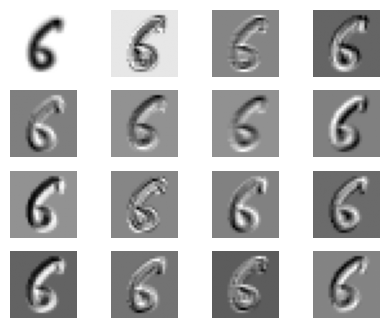

In [50]:
idx = np.random.randint(0, per_layer_results[0].shape[0]) # (0, 500)

plt.figure(figsize=(5, 4))
layer_visualisation = per_layer_results[0][idx, ...] # torch.Size([16, 26, 26])
layer_visualisation = layer_visualisation.data
print(layer_visualisation.size())
print(type(layer_visualisation))
for i, flt in enumerate(layer_visualisation):
    plt.subplot(4, 4, i + 1)
    plt.imshow(flt.cpu().detach(), cmap='gray')
    plt.axis("off")
plt.show()

torch.Size([32, 24, 24])


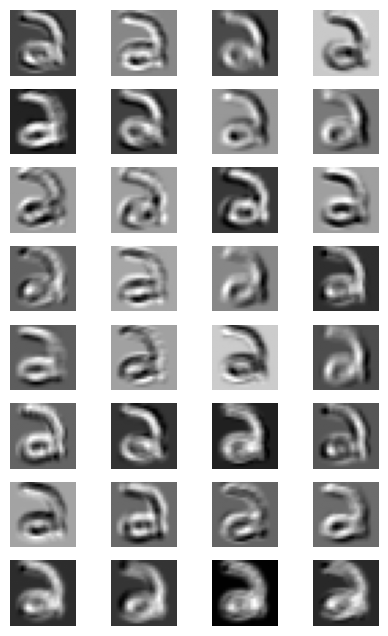

In [51]:
idx = np.random.randint(0, per_layer_results[1].shape[0]) # (0, 500)

plt.figure(figsize=(5, 8))
layer_visualisation = per_layer_results[1][idx, :, :, :]
layer_visualisation = layer_visualisation.data
print(layer_visualisation.size())
for i, flt in enumerate(layer_visualisation):
    plt.subplot(8, 4, i + 1)
    plt.imshow(flt.cpu().detach(), cmap='gray')
    plt.axis("off")
plt.show()

In [52]:
sample_data = sample_data.to(device)
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 0
Ground truth is : 0


### Grad-CAM with MNIST

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1) # This is the layer we want activations from
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 10)

        # Store a dictionary to hold activations and gradients
        self.feature_maps = {}
        self.gradients = {}

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        # Hook for forward pass to save feature maps
        # This will save the output of cn2 (after ReLU)
        # The save_feature_map_hook function itself is defined to accept three arguments:
        # module: The module to which the hook is attached (i.e., self.cn2).

        # input: A tuple containing the input tensor(s) to the self.cn2 module's forward method.
        # output: The output tensor(s) produced by the self.cn2 module's forward method.

        def save_feature_map_hook(module, input, output):
            self.feature_maps['cn2'] = output

        # Hook for backward pass to save gradients
        # This will save the gradients that flow back to the output of cn2
        def save_gradient_hook(module, grad_input, grad_output):
            # grad_output[0] is the gradient with respect to the output of the module
            self.gradients['cn2'] = grad_output[0]

        # Register the hooks to the cn2 layer
        # This hook function will be executed every time the self.cn2 module's forward method is called.
        self.cn2.register_forward_hook(save_feature_map_hook) # Attach a callback function: The function save_feature_map_hook will be called.
        self.cn2.register_backward_hook(save_gradient_hook)


    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x) # Activations stored here by the hook after this line

        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

In [ ]:
# device = torch.device("cuda")

model = ConvNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

for epoch in range(1, 10):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

output size =  torch.Size([1, 10])
CAM map shape: (28, 28)
Probabilities: [3.8667715e-13 8.1520354e-13 1.2652005e-09 4.0355116e-13 8.7134314e-11
 1.9436759e-12 2.7531848e-11 1.9117927e-14 1.0000000e+00 2.4349581e-10]
Probability for target class 8: 1.0000


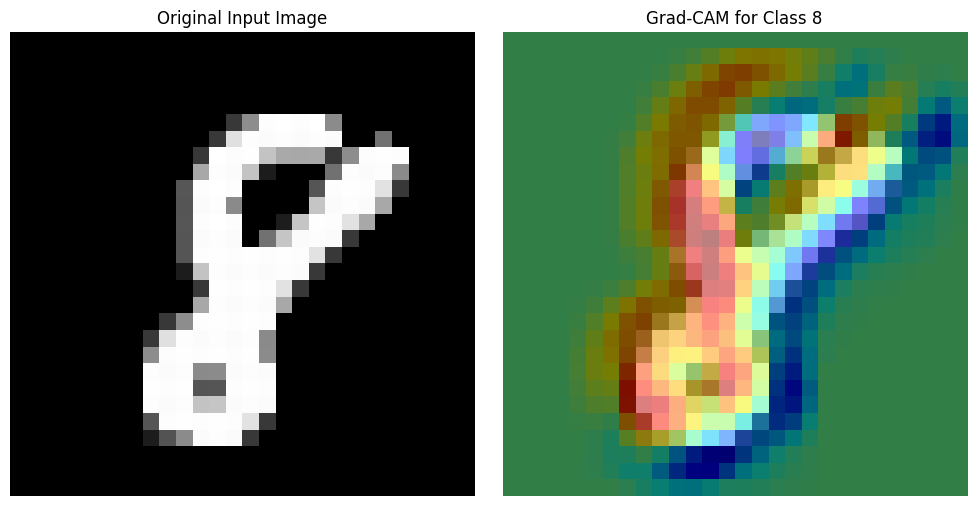

In [ ]:
def generate_cam(model, input_image, target_class):
    # Ensure the model is in evaluation mode
    model.eval()

    # Forward pass to get predictions and populate hooks
    output = model(input_image) # => (1, 10)

    probabilities = torch.exp(output) # Convert log_softmax to probabilities

    # Get the activations from the last convolutional layer (cn2)
    # These are stored via the forward hook
    activations = model.feature_maps['cn2'].cpu().detach()

    # --- Grad-CAM Implementation ---
    model.zero_grad() # Clear previous gradients

    # Get the score for the target class
    # output shape = torch.Size([1, 10])
    one_hot_output = torch.zeros_like(output, device=output.device) # Ensure device matches output
    one_hot_output[0][target_class] = 1 # Assuming batch size of 1

    # Perform backward pass to get gradients
    # This will populate model.gradients['cn2'] via the backward hook
    output.backward(gradient=one_hot_output)

    # Get the gradients with respect to the activations
    guided_gradients = model.gradients['cn2'].cpu().detach()

    # Global average pool the gradients across height and width
    weights = F.adaptive_avg_pool2d(guided_gradients, (1, 1))

    # Perform a weighted summation of the feature maps
    cam = (weights * activations).sum(dim=1, keepdim=True)


    # Normalize the CAM to the range [0, 1]
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Squeeze the batch and channel dimensions
    cam = cam.squeeze().numpy()

    # Resize the CAM to the original input image size
    original_h, original_w = input_image.shape[2], input_image.shape[3]
    cam = cv2.resize(cam, (original_w, original_h))

    return cam, probabilities.cpu().detach().numpy()[0]

# --- Example Usage ---
# Create a dummy input image (e.g., a 28x28 grayscale image like MNIST)
# Batch size of 1, 1 channel, 28x28 image
# dummy_input = torch.randn(1, 1, 28, 28).to(device)
dummy_input = sample_data[2].unsqueeze(0)

# Initialize the model
model = ConvNet().to(device)
model.load_state_dict(torch.load("mnist_gradCAM.pt", weights_only=True))

# Choose a target class (e.g., class 0)
target_class = 8

# Generate CAM
cam_map, probabilities = generate_cam(model, dummy_input, target_class)

print("CAM map shape:", cam_map.shape)
print("Probabilities:", probabilities)
print(f"Probability for target class {target_class}: {probabilities[target_class]:.4f}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(dummy_input.squeeze().cpu().numpy(), cmap='gray')
plt.title("Original Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dummy_input.squeeze().cpu().numpy(), cmap='gray') # Original image as background
plt.imshow(cam_map, cmap='jet', alpha=0.5) # Overlay CAM
plt.title(f"Grad-CAM for Class {target_class}")
plt.axis('off')

plt.tight_layout()
plt.show()

# This video provides a practical guide to implementing Grad-CAM for heatmap visualization using PyTorch and OpenCV.

# [GradCAM Implementation in PyTorch](https://www.youtube.com/watch?v=eLQZrNYqjNg)
# http://googleusercontent.com/youtube_content/0

## captum tools

In [27]:
print(sample_data.shape)
sample_data[0].unsqueeze(0).shape

torch.Size([500, 1, 28, 28])


torch.Size([1, 1, 28, 28])

In [28]:
captum_input = sample_data[0].unsqueeze(0) # torch.Size([1, 1, 28, 28])
captum_input.requires_grad = True

In [41]:
np.transpose((sample_data[0].cpu().detach().numpy() + 0.5 / 2), (1, 2, 0)).shape

(28, 28, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03787878..1.667074].


(28, 28, 3)


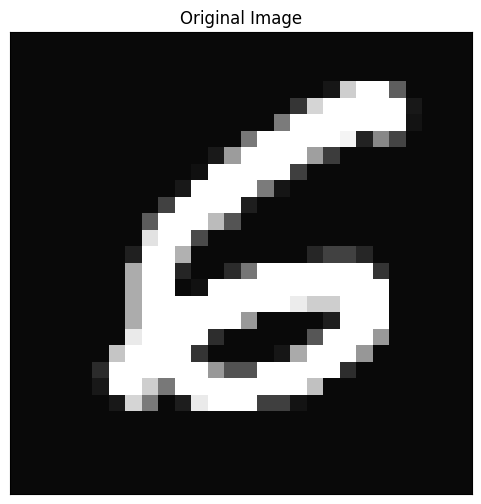

In [43]:
orig_image = np.tile(np.transpose(((sample_data[0].cpu().detach().numpy() + 0.5) / 2), (1, 2, 0)), (1,1,3))
print(orig_image.shape)

# orig_image = np.concatenate([tmp, np.zeros(tmp.shape), np.zeros(tmp.shape)], axis=2)
## None of overlaided image
_ = viz.visualize_image_attr(None, orig_image, cmap='gray', method="original_image", title="Original Image")  # a function that visualizes attribution maps over an image.

c:\Users\user\anaconda3\envs\torchgpu_py3.12\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


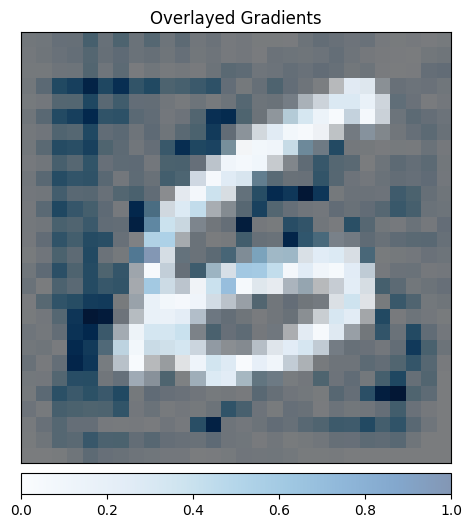

In [50]:
saliency = Saliency(model) # <class 'captum.attr._core.saliency.Saliency'>, gradient-based saliency map
gradients = saliency.attribute(captum_input, target=sample_targets[0].item()) 
# print(gradients.shape) # torch.Size([1, 1, 28, 28])

gradients = np.reshape(gradients.squeeze().cpu().detach().numpy(), (28, 28, 1))
_ = viz.visualize_image_attr(gradients, orig_image, method="blended_heat_map", 
                             sign="absolute_value",
                             show_colorbar=True, 
                             title="Overlayed Gradients")